## Classificação de frases por setor usando o KNN
#Autor: SRS

#Data: 12/10/2022
#Versão: 1

#Observações:


In [80]:
# Carregando bibliotecas
!pip install -U sentence-transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
# Abertura de arquivo
df = pd.read_csv('dataset.csv')
df.head()

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças
2,Então encontraremos na próxima aula.,educação
3,Veja os resultados da categoria de ofertas do ...,indústrias
4,"Além disso, a embalagem é reutilizável e 100% ...","indústrias,varejo"


## Visualização básica dos dados 

In [82]:
print(df['category'].unique())
print(len(df['category'].unique()))

['orgão público' 'finanças' 'educação' 'indústrias' 'indústrias,varejo'
 'varejo' 'finanças,varejo' 'educação,orgão público' 'educação,indústrias'
 'finanças,indústrias' 'finanças,orgão público' 'varejo,indústrias'
 'indústrias,orgão público' 'educação,finanças']
14


In [83]:
# Linhas e colunas
print('Qtde. de linhas e colunas', df.shape)
print('Nomes das colunas', df.columns)

Qtde. de linhas e colunas (521, 2)
Nomes das colunas Index(['sentence', 'category'], dtype='object')


In [84]:
# Tem features sem preenchimento?
print(df.isnull().sum())

sentence    0
category    0
dtype: int64


In [85]:
# Tem duplicidade ? 
print('Qtde. de duplicidades : ', df.duplicated().sum())
# Retirando as duplicidades
df.drop_duplicates(keep='first', inplace=True)
print('Removi as duplicidades')
# Numero de linhas e colunas atualizadas
print('Nova qtde. de linhas e colunas', df.shape)

Qtde. de duplicidades :  8
Removi as duplicidades
Nova qtde. de linhas e colunas (513, 2)


In [86]:
# Avaliando as quantidades por categorias
df["category"].value_counts()

orgão público               137
educação                    105
indústrias                   87
varejo                       84
finanças                     54
finanças,varejo              13
educação,orgão público        9
indústrias,varejo             7
educação,indústrias           5
finanças,orgão público        4
finanças,indústrias           3
indústrias,orgão público      2
educação,finanças             2
varejo,indústrias             1
Name: category, dtype: int64

In [87]:
# Tratando a categoria convertendo os tipos de texto para classificadores
condições = [(df['category'] == 'orgão público'), (df['category'] == 'educação'), (df['category'] == 'indústrias'),(df['category'] == 'varejo'),
             (df['category'] == 'finanças'),(df['category'] == 'finanças,varejo'),(df['category'] == 'educação,orgão público'),(df['category'] == 'indústrias,varejo'),
             (df['category'] == 'educação,indústrias'),(df['category'] == 'finanças,orgão público'),(df['category'] == 'finanças,indústrias'),
             (df['category'] == 'indústrias,orgão público'),(df['category'] == 'educação,finanças'),(df['category'] == 'varejo,indústrias')]

valores = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
df['target'] = np.select(condições, valores)

In [88]:
df.head()

,sentence,category,target
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público,1
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças,5
2,Então encontraremos na próxima aula.,educação,2
3,Veja os resultados da categoria de ofertas do ...,indústrias,3
4,"Além disso, a embalagem é reutilizável e 100% ...","indústrias,varejo",8


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Quantidade por categoria')

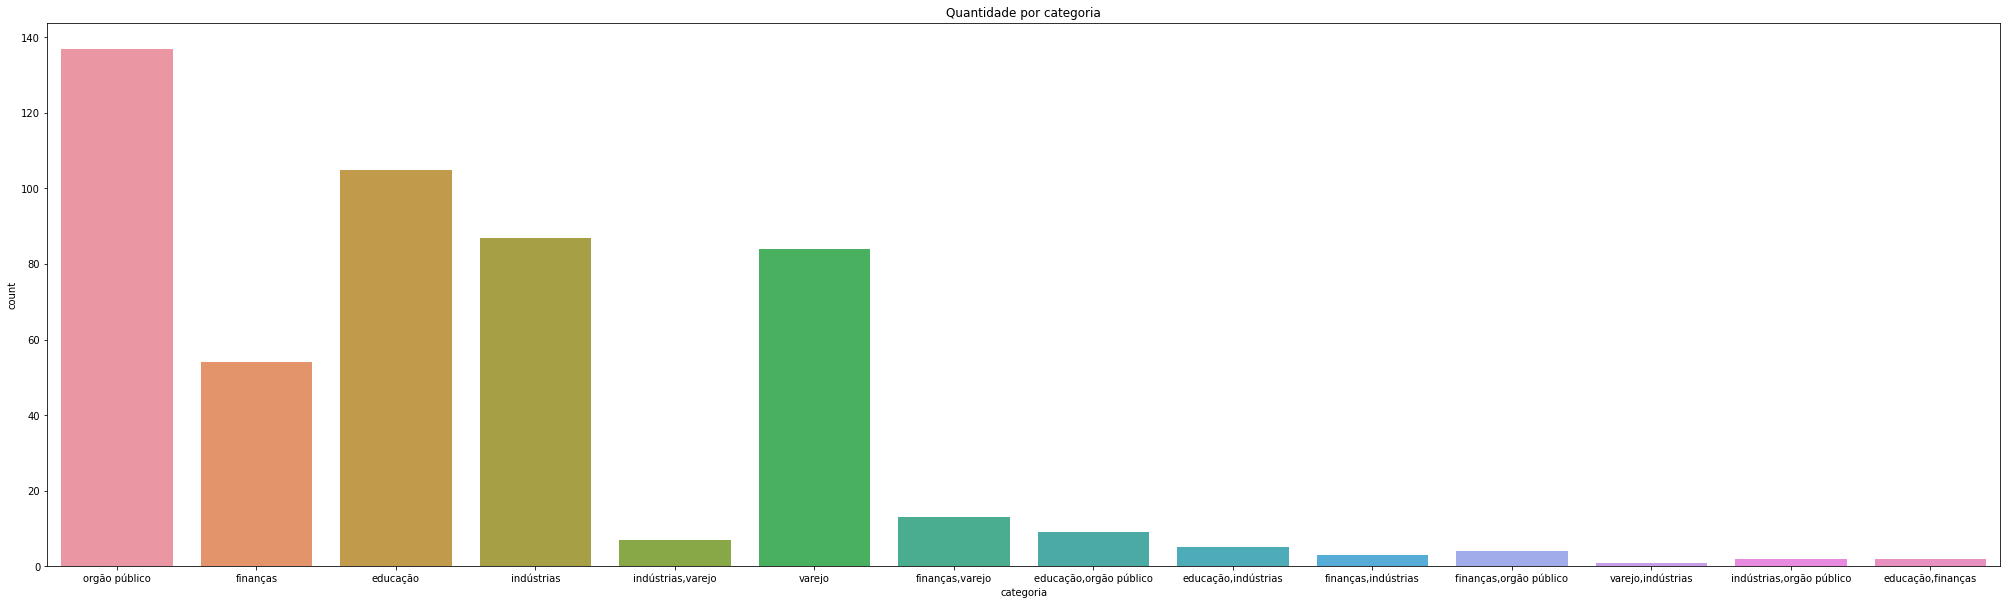

In [89]:
# Visualizando as quantidades por categoria
plt.figure(figsize=(35,10))
sns.countplot(df.category)
plt.xlabel('categoria')
plt.title('Quantidade por categoria')

# Pré-processamento dos Textos

Usando um modelo pré-treinado para extrair características dos textos nos dataframes sem e com tratamento da feature category.

In [90]:
# Carregando as características dos textos do modelo
text_feature_extractor = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

In [91]:
# Transfornando os textos em vetores
X = text_feature_extractor.encode(df.sentence.to_list())

In [92]:
# Visualizando os vetores criados
df['text'] = list(X)
df

,sentence,category,target,text
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público,1,"[-0.08659656, 0.1970878, -0.020183278, 0.00814..."
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças,5,"[-0.12397488, -0.033985425, -0.0115672, 0.1990..."
2,Então encontraremos na próxima aula.,educação,2,"[0.04774219, 0.21414632, -0.010318125, 0.10446..."
3,Veja os resultados da categoria de ofertas do ...,indústrias,3,"[-0.021570561, 0.09289247, -0.0049182507, 0.09..."
4,"Além disso, a embalagem é reutilizável e 100% ...","indústrias,varejo",8,"[0.17631179, -0.21903096, -0.011894866, -0.054..."
...,...,...,...,...
516,"Selecione o local de estudo, curso sem encontr...",educação,2,"[-0.19954486, 0.12061647, -0.010825499, -0.043..."
517,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,"educação,orgão público",7,"[-0.085093744, 0.15961227, -0.017924124, 0.040..."
518,Empresas e órgãos públicos,orgão público,1,"[-0.028186686, 0.27009827, -0.016615883, 0.071..."
519,DGE – Departamento de Gestão Estratégica Metas...,orgão público,1,"[0.069167435, 0.23252894, -0.017175842, -0.115..."


## Criando modelo KNN sem trasformar a feature category

In [93]:
# Coletando os dados e treino e testes
df_train, df_test = train_test_split(df, test_size=0.25, random_state=2)


In [94]:
# Visualização dos dados de treino
print('Qtde de Linhas para treinamento: ', df_train.shape[0])
print('Qtde de Linhas para teste: ', df_test.shape[0])

Qtde de Linhas para treinamento:  384
Qtde de Linhas para teste:  129


In [95]:
# Criando e treinando o modelo KNN com 3 sem converter a feature categoria
KNNv13 = KNeighborsClassifier(n_neighbors=3, metric='cosine')
KNNv13.fit(df_train['text'].to_list(), df_train['category'].to_list())

KNeighborsClassifier(metric='cosine', n_neighbors=3)

In [96]:
# Criando e treinando o modelo KNN com 3 convertendo a feature categoria
KNNv23 = KNeighborsClassifier(n_neighbors=3, metric='cosine')
KNNv23.fit(df_train['text'].to_list(), df_train['target'].to_list())

KNeighborsClassifier(metric='cosine', n_neighbors=3)

In [97]:
# Observando o resultado do modelo KNN com 3 sem converter a feature categoria
preds_v1_KNN3 = KNNv13.predict(df_test['text'].to_list())
df_test['preds_v1_KNN3'] = preds_v1_KNN3
df_test.sample(10)

,sentence,category,target,text,preds_v1_KNN3
278,Carro com porta malas de 435 Litros com espaço...,indústrias,3,"[0.09585558, -0.029587902, -0.010325139, 0.168...","finanças,varejo"
360,Secretaria de Meio Ambiente de Santo André res...,orgão público,1,"[-0.066027775, 0.5479196, -0.010722876, -0.018...",indústrias
511,Desejo receber ofertas no e-mail,varejo,4,"[0.025145704, 0.18878917, -0.010960886, 0.0129...",varejo
67,Etapa Educação Infantil,educação,2,"[-0.057257455, -0.019155743, -0.017857626, 0.0...",educação
378,R$ 5 de desconto ao mês.,finanças,5,"[-0.0722342, -0.05624622, -0.014796348, -0.019...",finanças
269,Curso de Técnico em Segurança do Trabalho por ...,"educação,finanças",13,"[-0.24005693, -0.03896529, -0.008509515, 0.115...",educação
154,Extrato de débitos,finanças,5,"[-0.051941384, 0.10952694, -0.017489316, 0.083...",finanças
305,Graduação Superior de Tecnologia em Automação ...,"educação,indústrias",9,"[-0.21805121, -0.060188066, -0.004846373, 0.11...",educação
146,Cadastro Nacional de Adoção (CNA) - Portal CNJ.,orgão público,1,"[-0.113858685, 0.30113047, -0.014392789, -0.00...",orgão público
32,Sua compra pode ser dividida em 15 ou 24 parce...,"finanças,varejo",6,"[-0.026148096, 0.056153297, -0.008982734, 0.05...",finanças


In [98]:
# Observando o resultado do modelo KNN com 3 convertendo a feature categoria
preds_v2_KNN3 = KNNv23.predict(df_test['text'].to_list())
df_test['preds_v2_KNN3'] = preds_v2_KNN3
df_test.sample(10)

,sentence,category,target,text,preds_v1_KNN3,preds_v2_KNN3
259,Documentação Trabalhadores da Limpeza Urbana.,orgão público,1,"[-0.14232527, 0.33353278, -0.016350657, -0.047...",orgão público,1
336,A maior produtora e exportadora de papéis para...,indústrias,3,"[-0.014207698, -0.14969932, -0.012727719, 0.15...",indústrias,3
424,"Com nossas florestas no Brasil, alcançamos a c...",indústrias,3,"[-0.074582264, 0.17854764, -0.01019499, -0.028...",indústrias,3
468,"Conecte-se ao Onix, o seu próximo hatch.",indústrias,3,"[-0.07808209, 0.0028290993, -0.016477484, 0.06...",indústrias,3
432,ATENDIMENTO ON-LINE DEFENSORIA PÚBLICA DO ESTA...,orgão público,1,"[-0.07779218, 0.17767699, -0.018568836, 0.0410...",orgão público,1
20,"Conheça mais dos prazos, editais e documentos ...",educação,2,"[-0.055599738, 0.18550734, -0.008544268, -0.07...",educação,2
419,Escolha o número de parcelas,varejo,4,"[-0.065280356, 0.02113638, -0.015441593, -0.01...",finanças,1
491,Emissão de Guias,orgão público,1,"[-0.008541264, 0.09006523, -0.017755201, 0.027...",educação,1
422,Dicas do Professor,educação,2,"[0.08135863, 0.016869271, -0.010019546, 0.0408...",educação,2
474,Formas de pagamento: cartões de crédito ou tra...,varejo,4,"[0.03568072, -0.12794472, -0.013846057, -0.006...",varejo,4


In [99]:
# Métricas do modelo KNN com 3 sem converter a feature categoria
print(classification_report(df_test['category'].to_list(), df_test['preds_v1_KNN3'].to_list()))

                          precision    recall  f1-score   support

                educação       0.74      0.95      0.83        21
       educação,finanças       0.00      0.00      0.00         1
     educação,indústrias       0.00      0.00      0.00         1
  educação,orgão público       0.00      0.00      0.00         3
                finanças       0.79      0.88      0.83        17
     finanças,indústrias       0.00      0.00      0.00         0
  finanças,orgão público       0.00      0.00      0.00         2
         finanças,varejo       0.00      0.00      0.00         4
              indústrias       0.75      0.71      0.73        21
indústrias,orgão público       0.00      0.00      0.00         0
       indústrias,varejo       1.00      1.00      1.00         1
           orgão público       0.87      0.87      0.87        38
                  varejo       0.71      0.75      0.73        20

                accuracy                           0.77       129
        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [100]:
# Métricas do modelo KNN com 3 convertendo a feature categoria
print(classification_report(df_test['target'].to_list(), df_test['preds_v2_KNN3'].to_list()))

              precision    recall  f1-score   support

           1       0.78      0.95      0.86        38
           2       0.77      0.95      0.85        21
           3       0.84      0.76      0.80        21
           4       0.62      0.80      0.70        20
           5       1.00      0.65      0.79        17
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         3
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1

    accuracy                           0.78       129
   macro avg       0.46      0.46      0.45       129
weighted avg       0.73      0.78      0.74       129



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# como o modelo com transformação ficou um pouco melhor, irei utilizar ele alterando a quantidade de neighbors no modelo para avaliar

In [101]:
# Criando e treinando o modelo KNN com 7 convertendo a feature categoria
KNNv27 = KNeighborsClassifier(n_neighbors=7, metric='cosine')
KNNv27.fit(df_train['text'].to_list(), df_train['target'].to_list())

KNeighborsClassifier(metric='cosine', n_neighbors=7)

In [102]:
# Observando o resultado do modelo KNN com 7 convertendo a feature categoria
preds_v2_KNN7 = KNNv27.predict(df_test['text'].to_list())
df_test['preds_v2_KNN7'] = preds_v2_KNN7
df_test.sample(10)

,sentence,category,target,text,preds_v1_KNN3,preds_v2_KNN3,preds_v2_KNN7
226,Relação das inscrições preliminarmente homolog...,orgão público,1,"[-0.0403015, 0.095946535, -0.011624888, -0.114...",orgão público,1,1
494,Valor da causa?,orgão público,1,"[-0.0031480591, 0.08917081, -0.0187741, 0.0881...",orgão público,1,1
194,Li e aceito as condições legais e a política d...,orgão público,1,"[-0.037050605, 0.28215003, -0.0049827695, -0.0...",orgão público,1,1
201,Com esse instrumento é possível se proteger de...,finanças,5,"[-0.03215281, 0.011103355, -0.014827141, 0.071...",finanças,5,5
141,Recall de segurança Chevrolet dos airbags Taka...,indústrias,3,"[-0.107631795, -0.09924837, -0.0053720456, 0.1...",indústrias,3,3
432,ATENDIMENTO ON-LINE DEFENSORIA PÚBLICA DO ESTA...,orgão público,1,"[-0.07779218, 0.17767699, -0.018568836, 0.0410...",orgão público,1,1
268,Juntada de Petição - Referente ao Evento: EXEC...,orgão público,1,"[-0.0142406775, 0.065573566, -0.020617293, -0....",orgão público,1,1
343,O banco pode fazer a redução de limite do cart...,finanças,5,"[-0.09371611, 0.071434826, -0.0133635085, -0.0...",finanças,5,5
160,Professores da rede municipal ganham mais opçõ...,"educação,orgão público",7,"[-0.07258245, 0.28036082, -0.015285406, 0.0082...",educação,2,2
468,"Conecte-se ao Onix, o seu próximo hatch.",indústrias,3,"[-0.07808209, 0.0028290993, -0.016477484, 0.06...",indústrias,3,3


In [103]:
# Métricas do modelo KNN com 7 convertendo a feature categoria
print(classification_report(df_test['target'].to_list(), df_test['preds_v2_KNN7'].to_list()))

              precision    recall  f1-score   support

           1       0.86      0.95      0.90        38
           2       0.77      0.95      0.85        21
           3       0.81      0.81      0.81        21
           4       0.67      0.80      0.73        20
           5       0.86      0.71      0.77        17
           6       1.00      0.25      0.40         4
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1

    accuracy                           0.79       129
   macro avg       0.45      0.41      0.41       129
weighted avg       0.76      0.79      0.76       129



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Validando o modelo

In [104]:
# criação das entradas para validação do modelo
texto_entrada1 = 'Ata do Fed reforça alta de juros, mesmo com efeitos colaterais'  #finanças
texto_entrada2 = 'Denúncias de corrupção assolam Conselho Federal de Administração'  #orgão público

In [105]:
# Usando modelo KNN3 - sem tranformar a feature Categoria
features1 = text_feature_extractor.encode([texto_entrada1])
features2 = text_feature_extractor.encode([texto_entrada2])
resultado1 = KNNv13.predict(features1)
resultado2 = KNNv13.predict(features2)
print('Resultado para a frase', texto_entrada1, 'é : ', resultado1)
print('Resultado para a frase', texto_entrada2, 'é : ', resultado2)

Resultado para a frase Ata do Fed reforça alta de juros, mesmo com efeitos colaterais é :  ['finanças']
Resultado para a frase Denúncias de corrupção assolam Conselho Federal de Administração é :  ['orgão público']


# Legenda

1.   orgão público
2.   educação
1.   indústrias
2.   varejo
1.   finanças
1.   finanças,varejo
1.   educação,orgão público
1.   indústrias,varejo
2.   educação,indústria
2.   finanças,orgão público
2.   finanças,indústrias
2.   indústrias,orgão público
1.   educação,finanças
2.   varejo,indústrias


In [106]:
# Usando modelo KNN7 - com a transformação da Categoria

features1 = text_feature_extractor.encode([texto_entrada1])
features2 = text_feature_extractor.encode([texto_entrada2])
resultado1 = KNNv27.predict(features1)
resultado2 = KNNv27.predict(features2)
print('Resultado para a frase', texto_entrada1, 'é : ', resultado1)
print('Resultado para a frase', texto_entrada2, 'é : ', resultado2)

Resultado para a frase Ata do Fed reforça alta de juros, mesmo com efeitos colaterais é :  [5]
Resultado para a frase Denúncias de corrupção assolam Conselho Federal de Administração é :  [1]
